<a href="https://colab.research.google.com/github/salmanromeo/1D_Pitching_Moment/blob/main/Lorenz96_pyMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip uninstall Theano Theano-PyMC PyMC3

In [ ]:
pip install PyMC3

In [ ]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
import pymc3 as pm

In [108]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import torch

In [109]:
def lorenz96(x, F):
    N = len(x)
    dxdt = torch.zeros(N)
    for k in range(N):
        dxdt[k] = (x[(k + 1) % N] - x[(k - 2)% N]) * x[(k - 1)% N] - x[k] + F
    return dxdt

def rk4(x, F, dt):
    k1 = lorenz96(x, F)
    k2 = lorenz96(x + 0.5 * dt * k1, F)
    k3 = lorenz96(x + 0.5 * dt * k2, F)
    k4 = lorenz96(x + dt * k3, F)
    x_new = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_new

In [110]:
# Set the number of States
N = 40

# Set the initial condition
x0 = torch.rand(N)

# Set the forcing term
F = 10.0

# Set the integration parameters
dt = 0.005;
t_start = 5.0
t_end = 10.0

# Create an array to store the time steps
t_steps = torch.arange(t_start, t_end, dt)
num_steps = len(t_steps)

# Create arrays to store the solutions
x_solution = torch.zeros((num_steps, N))
x_solution[0] = x0

# Number Of Parameters (For 2 neighbouring nodes)
N_P=21; 

In [111]:
# Perform the integration
for n in range(1, num_steps):
    x_solution[n] = rk4(x_solution[n - 1], F, dt)

X_state=x_solution # True state vaues

In [112]:
# True RHS
RHS_true = torch.zeros((num_steps, N)) 
for k in range(N):
    RHS_true[:,k]=(x_solution[:,(k + 1) % N] - x_solution[:,(k - 2)% N]) * x_solution[:,(k - 1)% N] - x_solution[:,k] + F

dx_dt_state=RHS_true; # True RHS

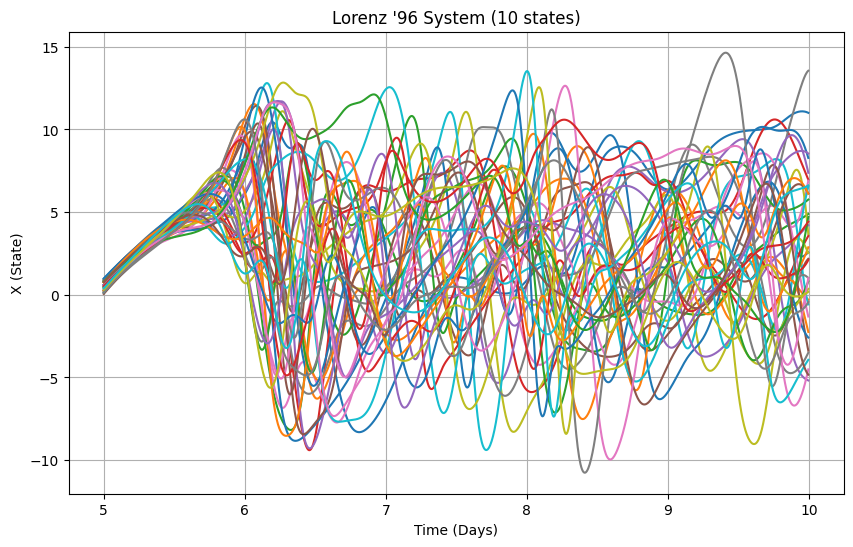

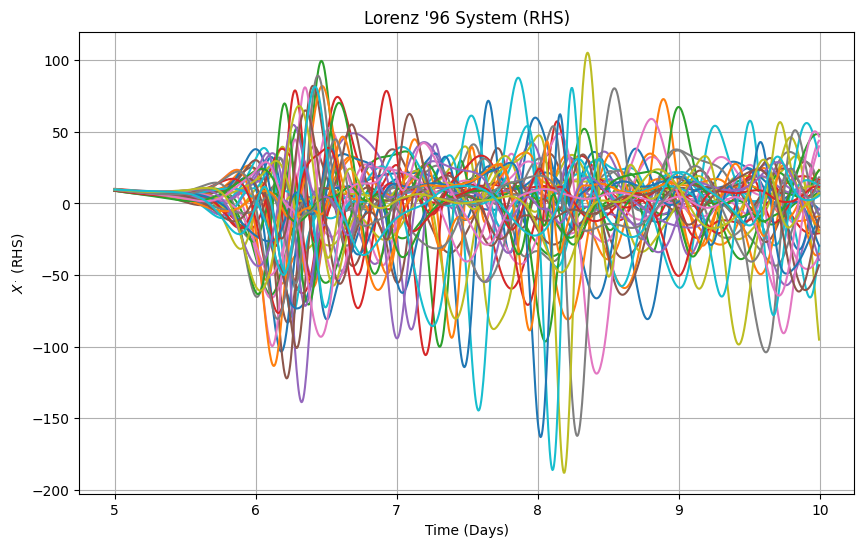

In [113]:
# Plot the solutions (X_state and X_dot)
plt.figure(figsize=(10, 6))
for k in range(N):
    plt.plot(t_steps, X_state[:, k], label=f'Variable {k+1}')
    plt.xlabel('Time')   
plt.xlabel('Time (Days)')
plt.ylabel('X (State)')
plt.title('Lorenz \'96 System (10 states)')
#plt.legend()
plt.grid(True)
plt.savefig('X_state.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
for k in range(N):
    plt.plot(t_steps, RHS_true[:, k], label=f'Variable {k+1}')
    plt.xlabel('Time')
plt.xlabel('Time (Days)')
plt.ylabel('$X^{.}$ (RHS)')
plt.title('Lorenz \'96 System (RHS)')
#plt.legend()
plt.grid(True)
plt.savefig('X_state_dot.png', dpi=300)
plt.show()

In [114]:
import numpy as np
import pymc3 as pm

# Define the assumed dynamics:
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

# Set the observed data
X_observed = np.vstack([
    X_state[:, (k - 2) % N].numpy(),
    X_state[:, (k - 1) % N].numpy(),
    X_state[:, k].numpy(),
    X_state[:, (k + 1) % N].numpy(),
    X_state[:, (k + 2) % N].numpy(),
]).T
Y_observed = dx_dt_state[:, k].numpy()

# Define the PyMC model
with pm.Model() as model:
    # Priors for the parameters
    d = pm.Normal("d", mu=0, sd=1, shape=N_P)
    
    # Expected value (assumed dynamics)
    mu = func(X_observed.T, d)
    
    # Likelihood
    Y = pm.Normal("Y", mu=mu, sd=1, observed=Y_observed)
    
    # Perform Bayesian inference
    trace = pm.sample(1000, tune=1000, cores=1)

# Get the estimated parameter values
estimated_params = trace["d"].mean(axis=0)
print("Estimated parameters:", estimated_params)

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


Estimated parameters: [ 9.74896649e+00  1.97833120e-02  4.81006648e-02 -9.98836375e-01
  2.37042331e-02  9.86180540e-03 -1.00510862e+00  3.50157409e-03
 -2.60462967e-03  2.65737892e-03  1.86010263e-04  9.94427003e-01
  1.07890994e-03 -1.61412752e-05 -3.68919136e-03  1.22396186e-03
 -1.48464490e-05 -9.44475881e-04  1.09439479e-03 -6.01186258e-05
 -2.68251112e-03]


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


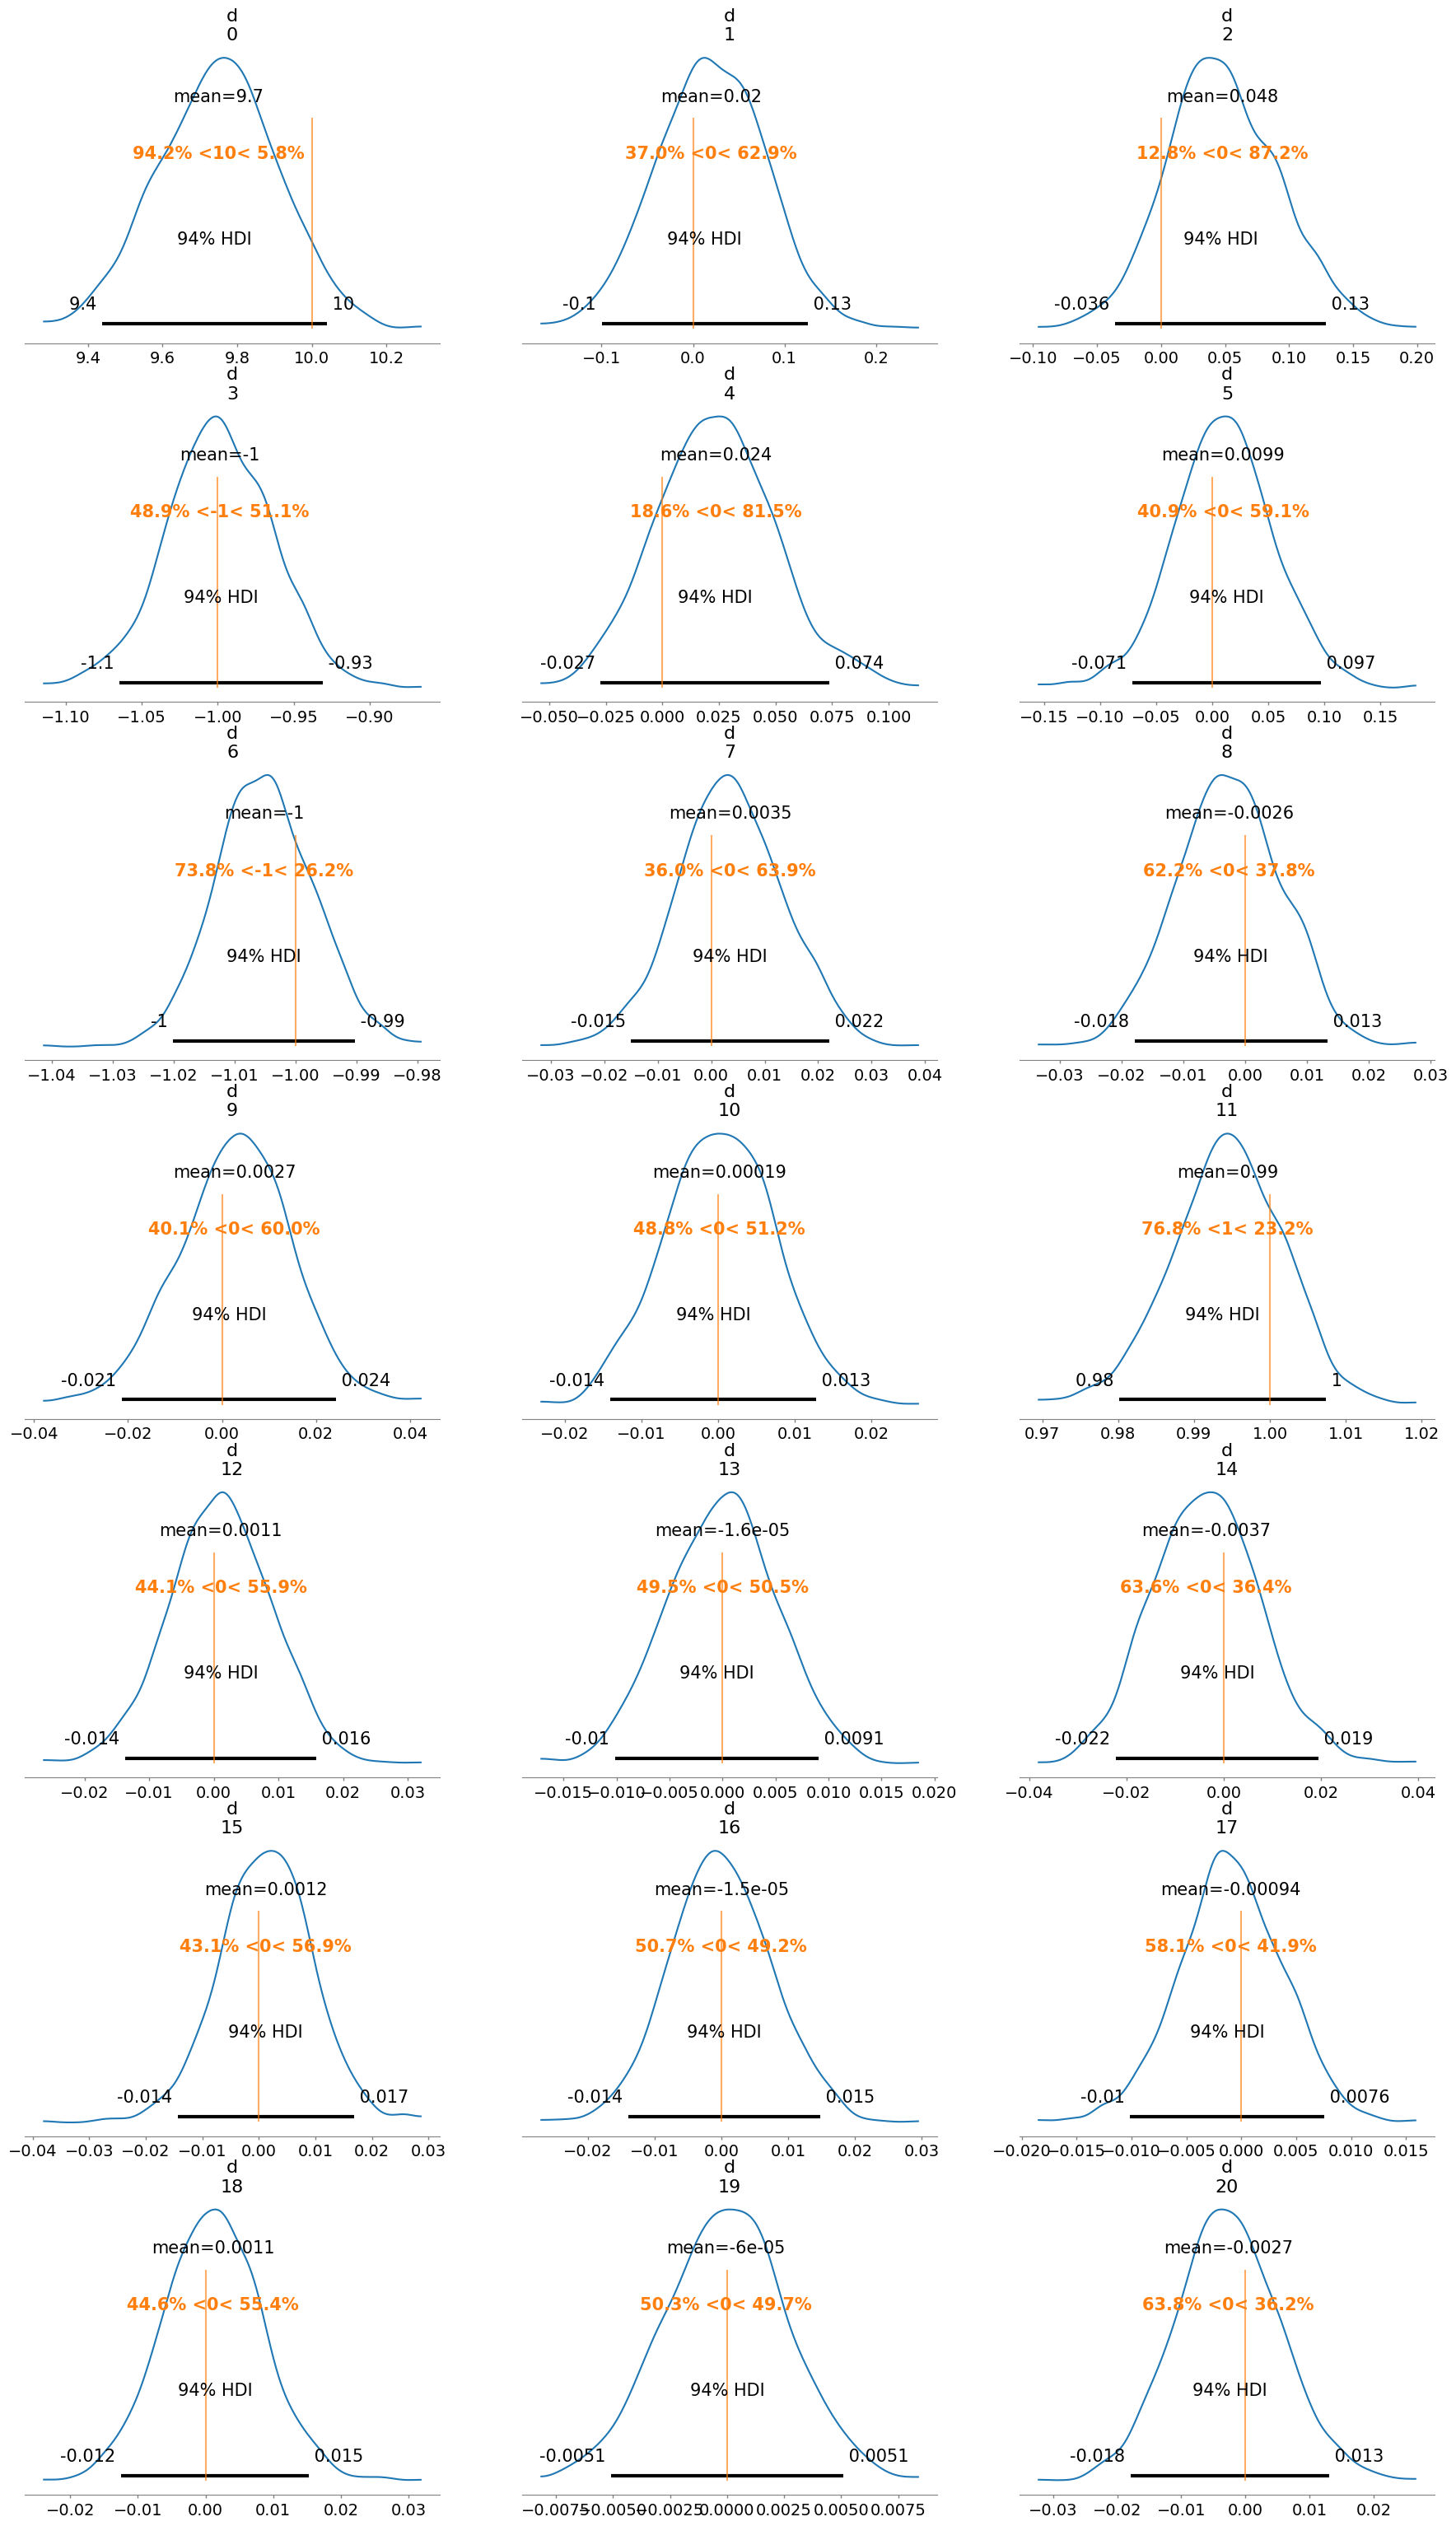

In [116]:
import arviz as az
# Define reference values for each parameter
ref_vals = [10, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # Replace with your desired reference values

# Plot the posterior distribution with reference values
az.plot_posterior(trace, var_names=["d"], ref_val=ref_vals)
plt.show()